# arXiv cs.CL Submission Date Analysis

In [0]:
!pip install -q feedparser

We will call the arXiv API to get the 4000 most recently submitted papers in cs.CL. As of November 17 this will get papers up until ~Nov 2015.

In [0]:
QUERY_URL = 'http://export.arxiv.org/api/query?search_query=cat:cs.CL&sortBy=submittedDate&start={}&max_results={}'

In [0]:
import feedparser
import time

papers = []
for i in range(0, 4000, 50):
  query = QUERY_URL.format(i, 50)
  res = feedparser.parse(query)
  for e in res.entries:
    papers.append({
        'title': e.title,
        'published': e.published_parsed,
        'authors': e.authors,
        'link': e.link
    })
  time.sleep(2)

Great! Now we have all the papers in `papers`. Let's analyze the submission times. A single paper look something like this:

In [12]:
papers[0]

{'authors': [{'name': u'Rajarshee Mitra'}],
 'link': u'http://arxiv.org/abs/1711.06238v1',
 'published': time.struct_time(tm_year=2017, tm_mon=11, tm_mday=16, tm_hour=18, tm_min=34, tm_sec=16, tm_wday=3, tm_yday=320, tm_isdst=0),
 'title': u'An Abstractive approach to Question Answering'}

In [0]:
import pandas as pd

papers_df = pd.DataFrame(papers)

Let's convert the published column to an actual datetime object.

In [0]:
papers_df['published'] = papers_df.apply(lambda r: '-'.join(map(lambda i: str(i).zfill(2), [r.published.tm_year, r.published.tm_mon, r.published.tm_mday])), axis=1).astype('datetime64')

In [34]:
papers_df.head()

,authors,link,published,title
0,[{u'name': u'Rajarshee Mitra'}],http://arxiv.org/abs/1711.06238v1,2017-11-16,An Abstractive approach to Question Answering
1,"[{u'name': u'Jia-Hong Huang'}, {u'name': u'Cuo...",http://arxiv.org/abs/1711.06232v1,2017-11-16,A Novel Framework for Robustness Analysis of V...
2,"[{u'name': u'Navid Rekabsaz'}, {u'name': u'Mih...",http://arxiv.org/abs/1711.06196v1,2017-11-16,Addressing Cross-Lingual Word Sense Disambigua...
3,"[{u'name': u'Lai Dac Viet'}, {u'name': u'Nguye...",http://arxiv.org/abs/1711.06141v1,2017-11-16,ConvAMR: Abstract meaning representation parsing
4,"[{u'name': u'Ruichu Cai'}, {u'name': u'Boyan X...",http://arxiv.org/abs/1711.06061v1,2017-11-16,An Encoder-Decoder Framework Translating Natur...


Let's look at a count of the papers published per month!

In [0]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (14, 6)

In [0]:
papers_monthly = papers_df.published.groupby([papers_df.published.dt.year, papers_df.published.dt.month]).count()

Text(0,0.5,u'Number of publications')

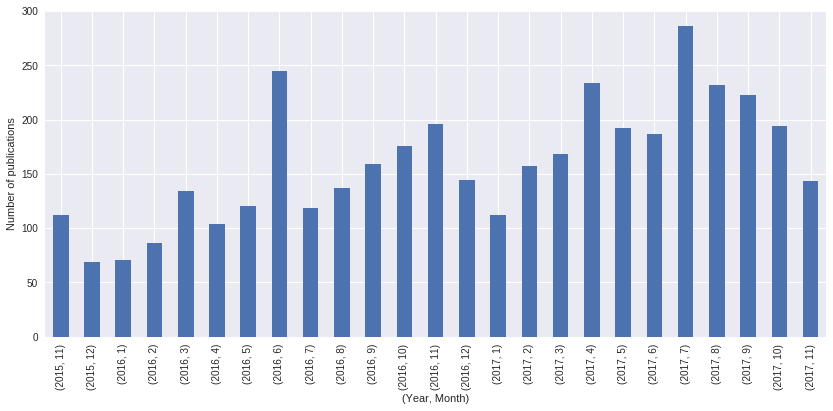

In [72]:
ax = papers_monthly.plot(kind='bar')
ax.set_xlabel('(Year, Month)')
ax.set_ylabel('Number of publications')

Here are the paper due dates of major NLP conferences:

**ACL 2016**:
  * Long paper: March 18, 2016 for submission, June 7 for camera-ready
  * Short paper: Feb 29, 2016 for submission, May 19 for camera-ready

**NAACL 2016**:
  * Long and short paper: January 6, 2016 for submission, April 1 for camera-ready

**EMNLP 2016**:
  * Long and short paper: June 3, 2016 for submission, September 23 for camera-ready
  
**ACL 2017**:
  * Long and short paper: February 6, 2017 for submission, April 22 for camera-ready

**EMNLP 2017**:
  * Long and short paper: April 14, 2017 for submission, July 21 for camera-ready

**NAACL 2018**:
  * Long paper: December 15, 2017 for submission
  * Short paper: January 10, 2018 for submission

## ACL 2016

Let's take a look right before ACL 2016 long and short paper deadlines.

Text(0,0.5,u'Number of publications')

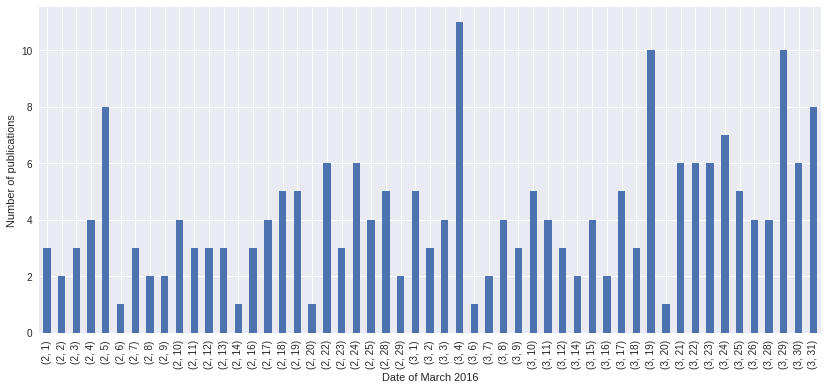

In [71]:
mar_16 = papers_df[(papers_df.published.dt.year == 2016) & (papers_df.published.dt.month.isin([2, 3]))]
ax = mar_16.published.groupby([mar_16.published.dt.month, mar_16.published.dt.day]).count().plot(kind='bar')
ax.set_xlabel('Date of March 2016')
ax.set_ylabel('Number of publications')

Higher than usual number of papers are published on March 4th, a few days after the February 29th short paper deadline. Also, higher than usual number of papers are published on March 19th, one day after the long paper deadline.

Also, let's take a look at June 2016. We see many papers published on June 7, 8, 9, 10, right after the ACL 2016 long paper camera-ready deadline.

Text(0,0.5,u'Number of publications')

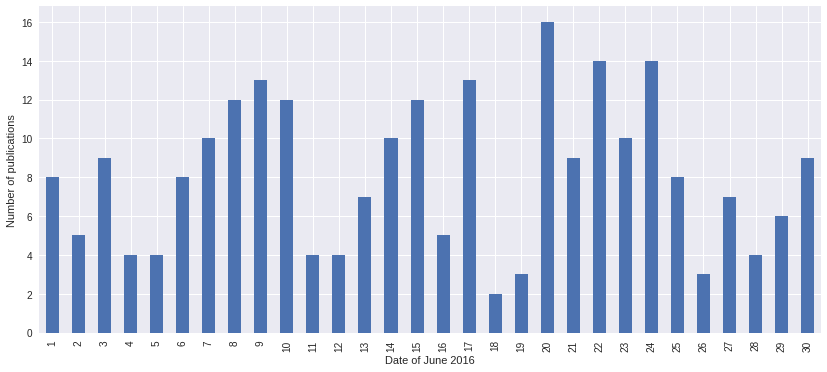

In [70]:
june_16 = papers_df[(papers_df.published.dt.year == 2016) & (papers_df.published.dt.month == 6)]
ax = june_16.published.groupby(june_16.published.dt.day).count().plot(kind='bar')
ax.set_xlabel('Date of June 2016')
ax.set_ylabel('Number of publications')

## NAACL 2016

Text(0,0.5,u'Number of publications')

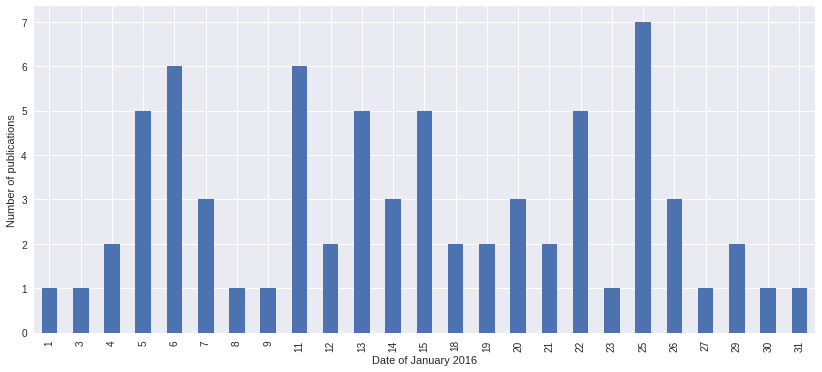

In [69]:
jan_16 = papers_df[(papers_df.published.dt.year == 2016) & (papers_df.published.dt.month == 1)]
ax = jan_16.published.groupby(jan_16.published.dt.day).count().plot(kind='bar')
ax.set_xlabel('Date of January 2016')
ax.set_ylabel('Number of publications')

The long and short papers are due on Jan 6th. Not sure if there's anything unusual here.

## ACL 2017

Text(0,0.5,u'Number of publications')

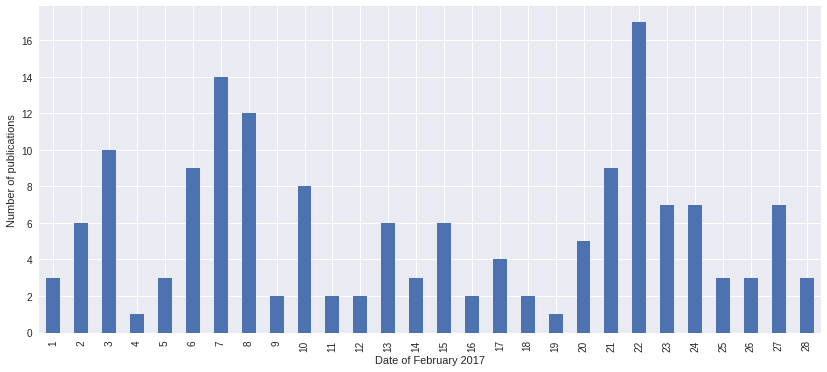

In [68]:
feb_17 = papers_df[(papers_df.published.dt.year == 2017) & (papers_df.published.dt.month == 2)]
ax = feb_17.published.groupby(feb_17.published.dt.day).count().plot(kind='bar')
ax.set_xlabel('Date of February 2017')
ax.set_ylabel('Number of publications')

Feb. 6th was the submission deadline. Lots of papers published on those days.

## NAACL 2018

Let's take a look around Nov. 14 based on new ACL arXiv rules. This is one month before long paper deadline.

Text(0,0.5,u'Number of publications')

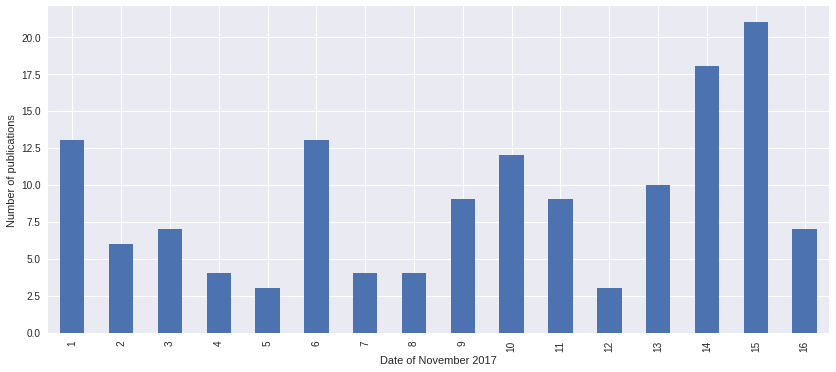

In [66]:
nov_17 = papers_df[(papers_df.published.dt.year == 2017) & (papers_df.published.dt.month == 11)]
ax = nov_17.published.groupby(nov_17.published.dt.day).count().plot(kind='bar')
ax.set_xlabel('Date of November 2017')
ax.set_ylabel('Number of publications')

Haha, yes, higher number of publications on Nov. 14 and 15. Seems yes, people just submit one month earlier? See hypotheses in https://twitter.com/lintool/status/928313098305396737, https://twitter.com/lintool/status/930461625647337473